In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Find the dataset @ (CSV files 2022-04-21, https://webrobots.io/kickstarter-datasets/)
# download link: https://s3.amazonaws.com/weruns/forfun/Kickstarter/Kickstarter_2022-04-21T03_20_08_060Z.zip

In [2]:
# get db connection
load_dotenv()
db_connection = os.getenv("KICKSTARTER_DB_URL")

# init database engine
engine = create_engine(db_connection)

In [3]:
# Query the database for data to build models.
query = """
        SELECT  state, 
                country, 
                fx_rate, 
                goal, 
                created_at, 
                launched_at, 
                state_changed_at, 
                deadline, 
                category.name, 
                parent_name 
        FROM kickstarters
        INNER JOIN category 
        ON kickstarters.id=category.kickstarter_id
        WHERE state='failed' OR state='successful';
        """
        #  	
model_data = pd.read_sql(query, engine)
model_data.head()

,state,country,fx_rate,goal,created_at,launched_at,state_changed_at,deadline,name,parent_name
0,successful,US,1.000000,5000.0,1609376406,1609545583,1611968831,1611968831,Cookbooks,Food
1,successful,HK,0.127500,350000.0,1606278560,1608912106,1614096106,1614096106,Cookbooks,Food
2,successful,ES,1.081901,50.0,1606477096,1606751262,1607900340,1607900340,Cookbooks,Food
3,successful,US,1.000000,65000.0,1604500905,1606194068,1610082068,1610082068,Cookbooks,Food
4,successful,GB,1.304140,10600.0,1605454727,1605981895,1608573895,1608573895,Cookbooks,Food


In [4]:
# create goal_usd column so that all goal amounts are in the same units, drop fx_rate and goals afterward
model_data['goal_usd'] = model_data['fx_rate']*model_data['goal']
model_data = model_data.drop(columns=['fx_rate', 'goal'])

# create total days active column as another metric
model_data['total_days_active'] = (model_data.deadline-model_data.launched_at)*0.00001157
model_data['launch_time'] = (model_data.launched_at-model_data.created_at)*0.00001157
model_data = model_data.drop(columns=['state_changed_at', 'deadline', 'launched_at'])

model_data = model_data.dropna()
model_data.head()

,state,country,created_at,name,parent_name,goal_usd,total_days_active,launch_time
0,successful,US,1609376406,Cookbooks,Food,5000.000000,28.036979,1.957378
1,successful,HK,1606278560,Cookbooks,Food,44624.926500,59.978880,30.470127
2,successful,ES,1606477096,Cookbooks,Food,54.095050,13.294832,3.172101
3,successful,US,1604500905,Cookbooks,Food,65000.000000,44.984160,19.589896
4,successful,GB,1605454727,Cookbooks,Food,13823.881138,29.989440,6.099334


### Encoding of non neumerical features

In [5]:
# split into X and y variables
X = model_data.drop(columns=['state'])
y = model_data.state

# encode boolean and string type columns
encoding_columns = (X.select_dtypes(include=['bool', 'object'])).columns
for column in encoding_columns:
    # Get one hot encoding of columns B
    dummies = pd.get_dummies(X[column])
    # Drop column B as it is now encoded
    X = X.drop(column, axis = 1)
    # Join the encoded df
    X = X.join(dummies, lsuffix='left', rsuffix='right')
    
# new encoder for y variable (to make sure that we can reverse encoding)
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)
X.head()

,created_at,goal_usd,total_days_active,launch_time,AT,AU,BE,CA,CH,DE,...,Art,Comics,Design,Film & Video,Food,Journalism,Music,Publishing,Technology,Theater
0,1609376406,5000.000000,28.036979,1.957378,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1606278560,44624.926500,59.978880,30.470127,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1606477096,54.095050,13.294832,3.172101,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1604500905,65000.000000,44.984160,19.589896,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1605454727,13823.881138,29.989440,6.099334,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Train/test splits for Test and Validation models.

In [6]:
# generate 70% train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                       random_state = 1,
                                                       stratify = y)

### Scale values using standard scaler

In [7]:
# init standard scaler
scaler = StandardScaler()

# scale Train and testing set, columns=X.columns to keep column headers.
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled.head()

,created_at,goal_usd,total_days_active,launch_time,AT,AU,BE,CA,CH,DE,...,Art,Comics,Design,Film & Video,Food,Journalism,Music,Publishing,Technology,Theater
0,-0.949228,-0.032128,-0.430693,-0.297957,-0.046438,-0.153214,-0.049195,-0.222922,-0.058055,-0.138382,...,-0.208257,-0.372172,-0.256482,3.352163,-0.376092,-0.294859,-0.436736,-0.407561,-0.361118,-0.277358
1,-0.645426,-0.035375,-0.266152,-0.327180,-0.046438,-0.153214,-0.049195,-0.222922,-0.058055,-0.138382,...,-0.208257,-0.372172,-0.256482,-0.298315,-0.376092,-0.294859,-0.436736,2.453623,-0.361118,-0.277358
2,-0.703120,-0.034401,-0.262786,-0.261069,-0.046438,-0.153214,-0.049195,-0.222922,-0.058055,-0.138382,...,-0.208257,-0.372172,-0.256482,-0.298315,-0.376092,-0.294859,2.289714,-0.407561,-0.361118,-0.277358
3,-1.150012,-0.035375,-0.168827,-0.137378,-0.046438,-0.153214,-0.049195,-0.222922,-0.058055,-0.138382,...,-0.208257,-0.372172,-0.256482,-0.298315,2.658926,-0.294859,-0.436736,-0.407561,-0.361118,-0.277358
4,-1.050177,-0.029529,-0.266152,-0.080621,-0.046438,-0.153214,-0.049195,-0.222922,-0.058055,-0.138382,...,-0.208257,-0.372172,-0.256482,-0.298315,-0.376092,-0.294859,-0.436736,-0.407561,-0.361118,3.605449


---

# Random Forest Classifier

In [8]:
# init and fit RF classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [9]:
# perform predictions on testing and validation data
predictions  = rf_classifier.predict(X_test_scaled)

In [10]:
# decode values using inverse transform
rf_predictions_decoded = y_encoder.inverse_transform(predictions)
y_test_decoded = y_encoder.inverse_transform(y_test)

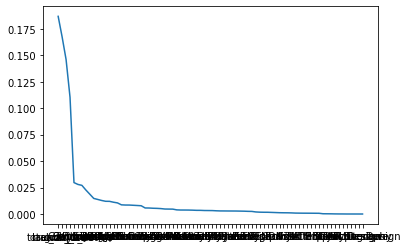

In [38]:
# view model importance of features for the model
importances = pd.DataFrame(zip(X.columns, rf_classifier.feature_importances_), columns = ['Feature','Importance value']).set_index('Feature').sort_values(by='Importance value', ascending=False)
plt.plot(importances)

In [12]:
# classification reports for the test and validation set
rf_report = classification_report(y_test_decoded, rf_predictions_decoded)
print (rf_report)

              precision    recall  f1-score   support

      failed       0.74      0.73      0.74      2759
  successful       0.86      0.87      0.87      5407

    accuracy                           0.82      8166
   macro avg       0.80      0.80      0.80      8166
weighted avg       0.82      0.82      0.82      8166



In [13]:
# view confusion matrix (0=failed, 1=success)
rf_cm = pd.DataFrame(confusion_matrix(y_test_decoded, rf_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
rf_cm

,Failed,Successful
Failed,2023,736
Successful,700,4707


In [14]:
# Calculate the ROC curve and AUC for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predictions)
auc_test = round(auc(fpr_test, tpr_test), 3)

# Create a DataFrame with the fpr and tpr results
roc_df_test = pd.DataFrame({"FPR Test": fpr_test, "TPR Test": tpr_test})

<AxesSubplot:title={'center':'Test ROC Curve (AUC=0.802)'}, xlabel='FPR Test'>

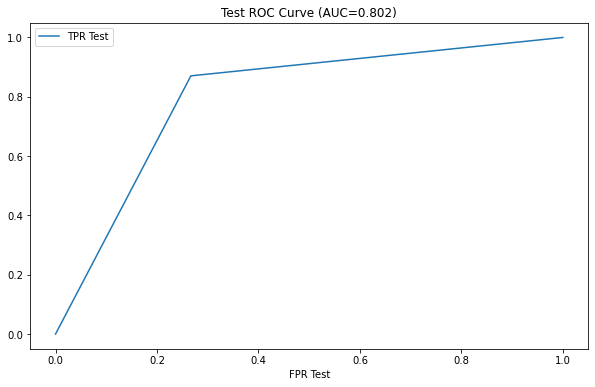

In [15]:
# Plot test set ROC curve
roc_df_test.plot(figsize = (10,6), x="FPR Test", y="TPR Test", title=f"Test ROC Curve (AUC={auc_test})")

---

# SVM Classifier

In [16]:
svm_classifier = SVC(kernel='linear', max_iter=500)
svm_classifier

SVC(kernel='linear', max_iter=500)

In [17]:
svm_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=500)

In [18]:
# Score the accuracy
svm_classifier.score(X_train_scaled, y_train)

0.6730698577651814

In [19]:
# Make predictions using the test data
svm_predictions = svm_classifier.predict(X_test_scaled)
svm_predictions_decoded = y_encoder.inverse_transform(svm_predictions)

In [20]:
# Display the confusion matrix
svm_cm = confusion_matrix(y_test_decoded, svm_predictions_decoded)
svm_cm = pd.DataFrame(confusion_matrix(y_test_decoded, svm_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
svm_cm

,Failed,Successful
Failed,366,2393
Successful,337,5070


In [21]:
# Calculate classification report
print(classification_report(y_test_decoded, svm_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.52      0.13      0.21      2759
  successful       0.68      0.94      0.79      5407

    accuracy                           0.67      8166
   macro avg       0.60      0.54      0.50      8166
weighted avg       0.63      0.67      0.59      8166



---
# SKLearn Neural Network Classifier

In [22]:
# init and fit Neural Networks classifier
nn_classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 2), random_state=1)

In [23]:
# Fit the data
nn_classifier.fit(X_train_scaled, y_train)

/Users/stuartperry/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(4, 2), random_state=1,
              solver='lbfgs')

In [24]:
nn_classifier.score(X_test_scaled, y_test)

0.8066372765123684

In [25]:
# Make predictions using the test data
nn_predictions = nn_classifier.predict(X_test_scaled)
nn_predictions_decoded = y_encoder.inverse_transform(nn_predictions)

In [26]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test_decoded, nn_predictions_decoded)
nn_cm = pd.DataFrame(confusion_matrix(y_test_decoded, nn_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
nn_cm

,Failed,Successful
Failed,2166,593
Successful,986,4421


In [27]:
# Calculate classification report
print(classification_report(y_test_decoded, nn_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.69      0.79      0.73      2759
  successful       0.88      0.82      0.85      5407

    accuracy                           0.81      8166
   macro avg       0.78      0.80      0.79      8166
weighted avg       0.82      0.81      0.81      8166



---
 # XGBoost Classifier

In [28]:
# init datasets as XGB matrices
xgb_train = xgb.DMatrix(np.array(X_train_scaled), label=np.array(y_train))
xgb_test = xgb.DMatrix(np.array(X_test_scaled), label=np.array(y_test))

# specify parameters via map
param = {
    'max_depth':5, 
    'eta':1, 
    'num_class':2, 
    'gamma':0,
    'max_depth':6,
    'min_child_weight':10,
    'num_parallel_tree':1
    }
num_round = 5

# fit XGB classifier
xgb_classifier = xgb.train(param, xgb_train, num_round)

In [29]:
# generate predictions
xgb_predictions = xgb_classifier.predict(xgb_test).astype(int)

In [30]:
xgb_predictions_decoded = y_encoder.inverse_transform(xgb_predictions)

In [31]:
# Display the confusion matrix
xgb_cm = confusion_matrix(y_test_decoded, xgb_predictions_decoded)
xgb_cm = pd.DataFrame(confusion_matrix(y_test_decoded, xgb_predictions_decoded), index=['Failed', 'Successful'], columns=['Failed', 'Successful'])
xgb_cm

,Failed,Successful
Failed,1954,805
Successful,737,4670


In [32]:
# Calculate classification report
print(classification_report(y_test_decoded, xgb_predictions_decoded))

              precision    recall  f1-score   support

      failed       0.73      0.71      0.72      2759
  successful       0.85      0.86      0.86      5407

    accuracy                           0.81      8166
   macro avg       0.79      0.79      0.79      8166
weighted avg       0.81      0.81      0.81      8166

